#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

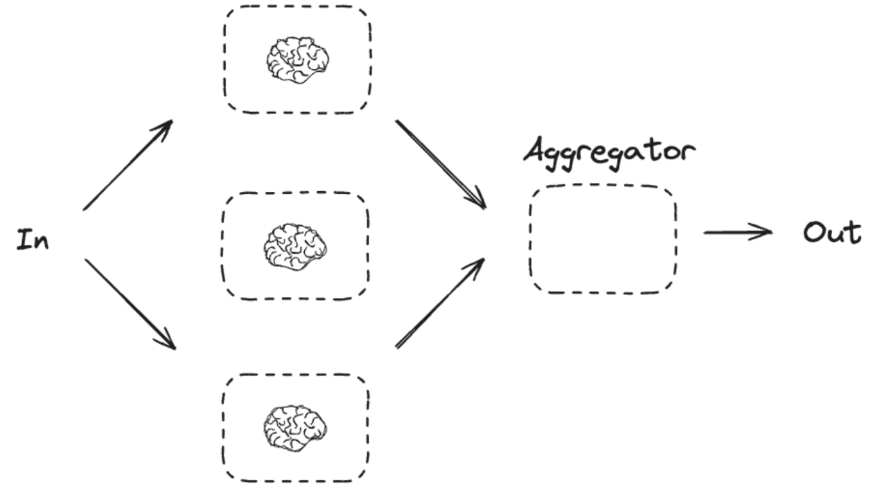

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

# from langchain_groq import ChatGroq
# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# llm=ChatGroq(model="qwen-qwq-32b")

llm = ChatOpenAI(model="gpt-4o")

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [5]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

In [6]:
# Build the graph
graph = StateGraph(State)
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

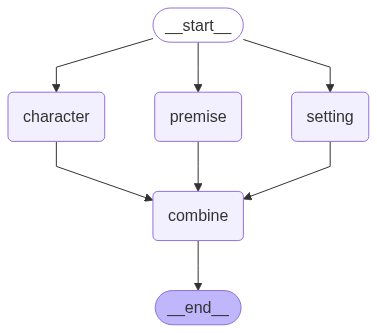

In [7]:
# Define edges (parallel execution from START)
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")

graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")

graph.add_edge("combine", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [8]:
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)

print(result["story_intro"])

Evelyn Frost stood at the edge of the village square, her gaze fixed on the ancient stone archway at its center. The ethereal light that cloaked its surface shifted like an iridescent veil, beckoning her with whispers of untold secrets. In the crisp mountain air, time seemed almost palpable, like the flow of the gentle stream that wound through the valley. Behind Evelyn, cobblestone streets bustled with townsfolk dressed in a fusion of historical and futuristic garb—a vivid canvas of eras interwoven with effortless grace.

Evelyn's heart quickened, a familiar thrill of discovery coursing through her veins. She had spent years unraveling the scientific intricacies of temporal mechanics, her theories dismissed by many as fantastical. Yet here, in this hidden village ensconced between jagged peaks, she felt the tantalizing proximity of proof.

Her solitary pursuits were about to intersect with an unexpected alliance. Just as the bells of the clock tower rang out, their harmonious dissonan

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.

